In [72]:
import mechanicalsoup
from bs4 import BeautifulSoup
from requests_html import HTMLSession
import dateutil.parser
import datetime
import sys
import json
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
session = HTMLSession()
browser = mechanicalsoup.StatefulBrowser()
browser.addheaders = [('User-agent', 'Firefox')]


In [11]:
def get_games(date):
    '''
        Get NBA games on a particular day
        The data is being screapped from the espn.com site
        date:   YYYYMMDD format
    '''

    games_dict = {}
    gameIndex = 0

    browser.open("https://www.espn.com/nba/schedule/_/date/"+date) # URL containig the games for the given date 

    # Opening the link
    schedule_link = browser.find_link()
    browser.follow_link(schedule_link)

    page = browser.get_current_page() # get the page source code
    games = page.find(class_="schedule has-team-logos align-left") # select only the tag that contains the games' info
    desc_all = games.find_all('small') # Game description

    # return games_dict
    for game in games.find_all('tr'):
        teams = []

        contents = game.find_all('td')
        for content in contents:
            for td in content.find_all('abbr'):
                teams.append(td.get('title'))

        if contents:
            element_list = str(contents[2]).split('>')
            gameId = str(element_list[1][52:-36]) # Isolates the game ID
            date = str(element_list[0][41:-1]) # Isolates the result
            time = str(dateutil.parser.parse(date))[:-9] # Converts date time from ISO 8601:

            teams.reverse() # Inverts the order to use the Home vs. Away format
            games_dict[gameId] = teams , time # Adds the game to a dictionary using the ID as key

            gameIndex+=1

    return games_dict

In [12]:
def get_results(date):
    '''
        Get the results NBA games on a particular day
        The data is being screapped from the espn.com site
        date:   YYYYMMDD format
    '''

    games_dict = {}
    gameIndex = 0

    browser.open("https://www.espn.com/nba/schedule/_/date/"+date) # URL containig the games for the given date 

    # Opening the link
    schedule_link = browser.find_link()
    browser.follow_link(schedule_link)

    page = browser.get_current_page() # get the page source code
    games = page.find(class_="schedule has-team-logos align-left") # select only the tag that contains the games' info

    for game in games.find_all('tr'):
        teams = []

        contents = game.find_all('td')
        for content in contents:
            for td in content.find_all('abbr'):
                teams.append(td.get('title'))

        if contents:
            element_list = str(contents[2]).split('>')
            gameId = str(element_list[1][28:-37]) # Isolates the game ID
            result = str(element_list[2][:-3]) # Isolates the result

            teams.reverse() # Inverts the order to use the Home vs. Away format
            games_dict[gameId] = teams , result # Adds the game to a dictionary using the ID as key

            gameIndex+=1

    return games_dict

In [13]:
def DictToDf(dic):
    '''
    Convert dictionary generated from scrapping to a Pandas Dataframe
    dic: {'gameID': (['Home', 'Away'], 'WIN_ABREV WIN_POINTS, LOS_ABREV LOS_POINTS'
    '''
    
    df = pd.DataFrame.from_dict(dic,orient='index')
    
    # Getting Home and Away teams from list and creating a column for each of them
    df.loc[:, 'Home'] = df[0].map(lambda x: x[0]) 
    df.loc[:, 'Away'] = df[0].map(lambda x: x[1])
    df = df.drop(0,axis=1)
    
    df = df.rename(columns={1: "Result"})
    df.index.name = "Game_ID"

    return df

In [14]:
def getAbrev():
    '''
    Scrapes Wikipedia page to get a dictionary with NBA teams names and abreviations
    '''
    
    url2 = "https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations"

    response = requests.get(
        url=url2,
    )
    soup = BeautifulSoup(response.content, 'html.parser')

    results = {}
    for row in soup.findAll('tr'):
        aux = row.findAll('td')
        try:
            results[aux[0].string[:-1]] = aux[1].find('a').text
        except:
            pass
    
    results["NY"] =  results["NYK"]
    results["UTAH"] =  results["UTA"]
    results["NO"] =  results["NOP"]
    results["SA"] =  results["SAS"]
    results["WSH"] =  results["WAS"]
    results["LAC"] = "LA Clippers"
    results["GS"] =  results["GSW"]
    
    
    return results

In [15]:
def formatResult(df):
    '''
    Formats the Dataframe 
    '''
    
    Won = []
    Won_Points = []
    Lost = []
    Lost_Points = []
    abrev = getAbrev()

    for r in range(len(df.Result)):
        row=df.Result[r]
        teams = row.split(',')
        name_res = [team.split(' ') for team in teams]

        if name_res[0][0] in abrev and  name_res[1][1] in abrev:
            Won.append(abrev[name_res[0][0]])
            Won_Points.append(name_res[0][1])

            Lost.append(abrev[name_res[1][1]])
            Lost_Points.append(name_res[1][2])

        else: # Days without games or with exibition matches or postponed
           pass

    if name_res[0][0] != "Postponed":
        df["Won"] = Won
        df["Won_Points"] = Won_Points
        df["Lost"] = Lost
        df["Lost_Points"] = Lost_Points

        df['Home_Won'] = np.where((df['Home'] == df['Won']), "Yes", "No")
    
    return df

In [16]:
def getByDay(date):
    '''
    Creates a Dataframe with de scraped and cleaned data for a specific day
    date:   DD/MM/YYYY format
    '''

    now = datetime.datetime.now()

    # Changing the date format to use in the URL
    date_split = date.split('/')
    date = [date_split[2],date_split[1],date_split[0]]
    date = ''.join(date)

    #Checking if the given date is in the past
    if now.year > int(date_split[2]) or now.month > int(date_split[1]) or now.day > int(date_split[0]):
        dic = get_results(date)
        df = DictToDf(dic)
        df["Date"] = [date]*len(df)

        df = formatResult(df)
        
        # df.to_csv('./games/games'+date+'.csv')
        
        return df

    else:
        dic = get_games(date)
        df = DictToDf(dic)
        df["Date"] = [end_date]*len(df)
        # df.to_csv('./dates/dates'+date+'.csv')
        
        return df

In [17]:
def main(start_date, end_date):
    dfs = []
    
    for day in pd.period_range(start=start_date, end=end_date, freq='D'):
        try:
            dfs.append(getByDay(str(day.strftime("%d/%m/%Y"))))
        except:
            pass
#             print(day)
            
    return dfs

In [18]:
# # Extracting 
# start_date = "14/03/2021"
# end_date = "20/04/2021"

# dfs = main(start_date, end_date)

In [19]:
# result = pd.concat(dfs)
# result

In [20]:
# result.to_csv('./games/games.csv')

### Gráficos pra se fazer
- boxplot com home e away por temporada
- pizza vitoria home vitoria away por temporada
- histograma da diferença de pontos entre home e away por temporada
- normalized cumulative function da diferença de pontos entre home e away por temporada
-  

## Criando arquivos para análise

Após desenvolver as funções necessárias para extrair os jogos de qualquer data do site da ESPN, vamos criar arquivos para as diferentes épocas que queremos analisar.

- Temporada Regular 2018-19: público normal - 82 jogos por time
- Playoffs 2018-19: público normal
- Temporada Regular 2019-20: público normal(interrompida) - 63-67 jogos por time
- Playoffs 2019-20: sem público
- Temporada Regular 2020-2021: sem público - 72 jogos por time

In [24]:
def concatCSV(start_date,end_date,path_to_save,name):
    '''
    Concats different DataFrames with games of the day into a single one
    and exports it to csv
    '''
    dfs = main(start_date,end_date)
    total_df = pd.concat(dfs)
    total_df.to_csv(path_to_save+name+'.csv')

In [22]:
path = "./games/"

In [29]:
# concatCSV("16/10/2018","10/04/2019",path,"regular_2018-19")
# concatCSV("13/04/2019","25/05/2019",path,"playoffs_2018-19") # bug
# concatCSV("22/10/2019","11/03/2020",path,"regular_2019-20")
# concatCSV("17/08/2020","11/10/2020",path,"playoffs_2019-20") # bug
# concatCSV("22/12/2020","16/04/2021",path,"regular_2020-21")

In [47]:
regular_18_19 = pd.read_csv('./games/regular_2018-19.csv')
regular_18_19['Season'] = "2018-19"
regular_20_21 = pd.read_csv('./games/regular_2020-21.csv')
regular_20_21['Season'] = "2020-21"

In [48]:
df = pd.concat([regular_18_19,regular_20_21])

In [49]:
df['Home_Points'] = np.where((df['Home_Won'] == 'Yes'), df['Won_Points'], df['Lost_Points'])
df['Away_Points'] = np.where((df['Home_Won'] == 'Yes'), df['Lost_Points'], df['Won_Points'])

In [53]:
df.head()

,Game_ID,Result,Home,Away,Date,Won,Won_Points,Lost,Lost_Points,Home_Won,Season,Home_Points,Away_Points
0,401070213,"BOS 105, PHI 87",Boston Celtics,Philadelphia 76ers,20181016,Boston Celtics,105.0,Philadelphia 76ers,87.0,Yes,2018-19,105.0,87.0
1,401070214,"GS 108, OKC 100",Golden State Warriors,Oklahoma City Thunder,20181016,Golden State Warriors,108.0,Oklahoma City Thunder,100.0,Yes,2018-19,108.0,100.0
2,401070693,"MIL 113, CHA 112",Charlotte Hornets,Milwaukee Bucks,20181017,Milwaukee Bucks,113.0,Charlotte Hornets,112.0,No,2018-19,112.0,113.0
3,401070694,"DET 103, BKN 100",Detroit Pistons,Brooklyn Nets,20181017,Detroit Pistons,103.0,Brooklyn Nets,100.0,Yes,2018-19,103.0,100.0
4,401070695,"IND 111, MEM 83",Indiana Pacers,Memphis Grizzlies,20181017,Indiana Pacers,111.0,Memphis Grizzlies,83.0,Yes,2018-19,111.0,83.0


## Boxplot

Text(0.5, 1.0, '2020-21 Regular Season')

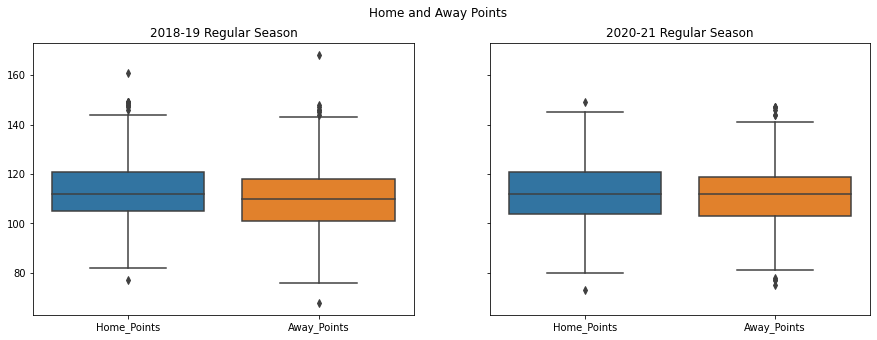

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5),sharey=True)
fig.suptitle('Home and Away Points')

sns.boxplot(ax = axes[0], data=df.loc[df['Season']=='2018-19'][['Home_Points','Away_Points']])
axes[0].set_title('2018-19 Regular Season')
sns.boxplot(ax = axes[1], data=df.loc[df['Season']=='2020-21'][['Home_Points','Away_Points']])
axes[1].set_title('2020-21 Regular Season')


## Pie Chart

In [1]:
f = plt.figure(figsize=(16,8))
f.suptitle('Home Team won?')

ax0 = plt.subplot(121)
ax0.set_title('2018-19 Regular Season')
df.loc[df['Season']=='2018-19'][['Home_Won']].value_counts().plot.pie(subplots=True)

ax1 = plt.subplot(122)
ax1.set_title('2020-21 Regular Season')
df.loc[df['Season']=='2020-21'][['Home_Won']].value_counts().plot.pie(subplots=True)

plt.show()

NameError: name 'plt' is not defined

## Histogram

In [104]:
df['diff'] = df['Home_Points'] - df['Away_Points']

Text(0.5, 1.0, '2020-21 Regular Season')

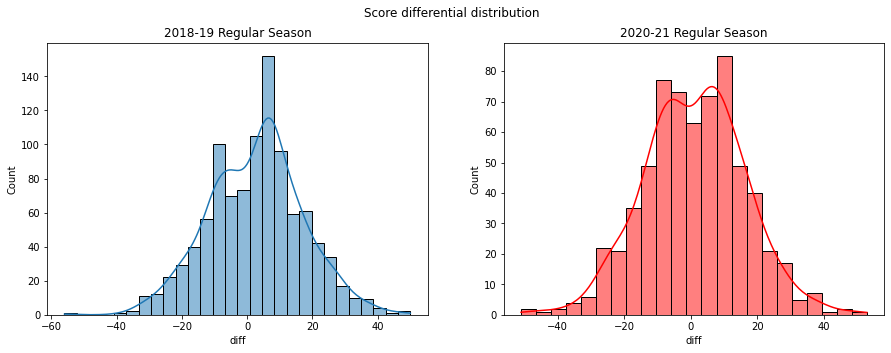

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Score differential distribution')

sns.histplot(ax = axes[0],data=df.loc[df['Season']=='2018-19'][['diff']], x="diff", kde=True)
axes[0].set_title('2018-19 Regular Season')
sns.histplot(ax = axes[1],data=df.loc[df['Season']=='2020-21'][['diff']], x="diff", kde=True,color='red')
axes[1].set_title('2020-21 Regular Season')

## CDF Plot

<AxesSubplot:xlabel='diff', ylabel='Proportion'>

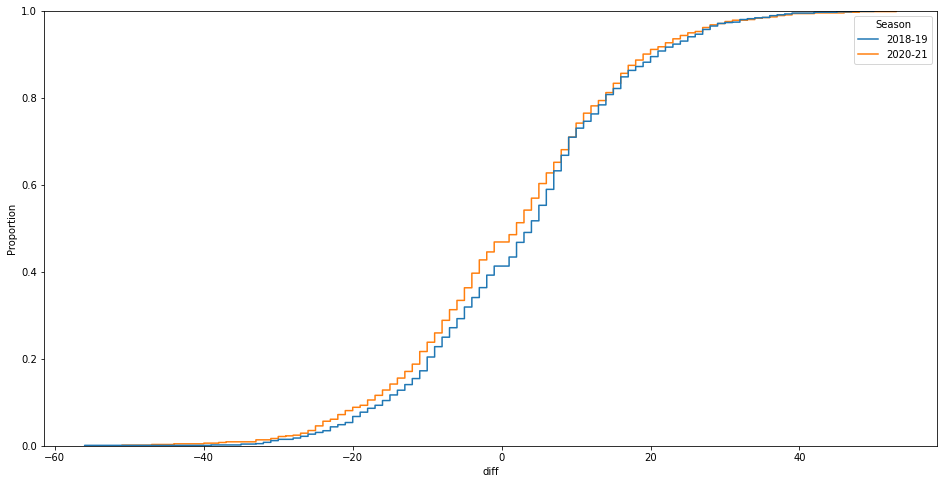

In [136]:
plt.figure(figsize=(16,8))
sns.ecdfplot(data=df[['diff','Season']], x="diff", hue="Season")